[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/Homeworks/blob/main/Part_4/Task_3_CV2.ipynb)

# Домашнее задание 3
- Обучить AE собственной архитектуры на MNIST
- Обучить VAE собственной архитектуры на MNIST
- *Обучить VAE c переносом стиля на MNIST (на вход декодеру подавать hidden с таргетным значением, чтобы можно было нарисовать заданную цифру в заданном стиле)

In [5]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/opt/anaconda3/envs/ds_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Задание 1
Обучить AE собственной архитектуры на MNIST

### Гиперпараметры

In [40]:
input_channels = 1      # один канал на входе (1 черно-белая картинка)
hidden_channels = 32    # количество матриц с результатами свертки
device_id = -1
device = 'mps' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 20
batch_size = 64

### Архитектура модели

In [41]:
class ConvEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 28x28
    self.do1 = nn.Dropout(0.2)
    
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 28x28
    self.do2 = nn.Dropout(0.2)   
    self.pool1 = nn.MaxPool2d(2, 2) # 14x14
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do3 = nn.Dropout(0.2)
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do4 = nn.Dropout(0.2)

    self.pool2 = nn.MaxPool2d(2, 2) # 7x7
    self.conv5 = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1,   # out_ch = 1 - все фичи утрамбовываются в 1 матрицу 7x7
                           padding=1) # 7x7
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do2(self.activ(self.conv2(self.do1(self.activ(self.conv1(x)))))))
    x = self.pool2(self.do4(self.activ(self.conv4(self.do3(self.activ(self.conv3(x)))))))
    x = self.conv5(x)

    return x

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.do1 = nn.Dropout(0.2)

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.do2 = nn.Dropout(0.2)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14x14       # обратная пулингу операция
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do3 = nn.Dropout(0.2)
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do4 = nn.Dropout(0.2)

    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    self.conv5 = nn.Conv2d(hidden_ch, input_ch, kernel_size=3, stride=1, 
                           padding=1) # 28x28
    self.activ = nn.ReLU()
  def forward(self, x):
    x = self.upsample1(self.do2(self.activ(self.conv2(self.do1(self.activ(self.conv1(x)))))))
    x = self.upsample2(self.do4(self.activ(self.conv4(self.do3(self.activ(self.conv3(x)))))))
    x = self.conv5(x)


    return x

class ConvAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_

### Загрузчик данных

In [42]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])

# скачивание обучающего датасета
dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

# скачивание тестового датасета
dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

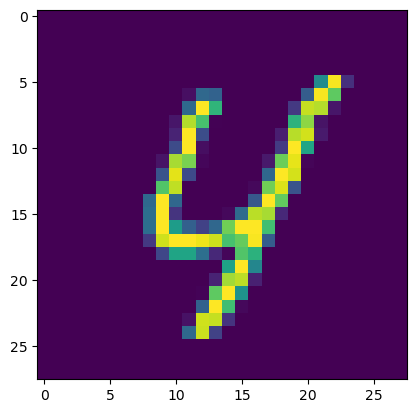

In [43]:
plt.imshow(dataset_test.data[555].detach().numpy())
plt.show()

### Инициализация модели, задание оптимизатора и функции потерь

In [44]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss()

### Трейн луп

epoch: 0, step: 0, loss: 0.9126867055892944
epoch: 0, step: 200, loss: 0.29762914776802063
epoch: 0, step: 400, loss: 0.1784246414899826
epoch: 0, step: 600, loss: 0.15984298288822174
epoch: 0, step: 800, loss: 0.14226874709129333


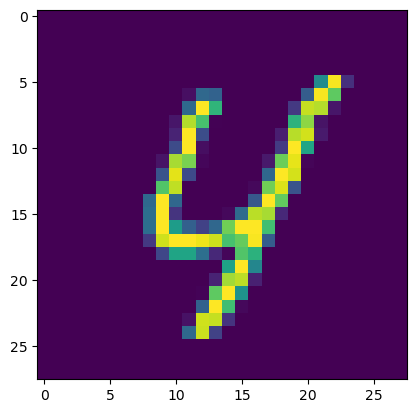

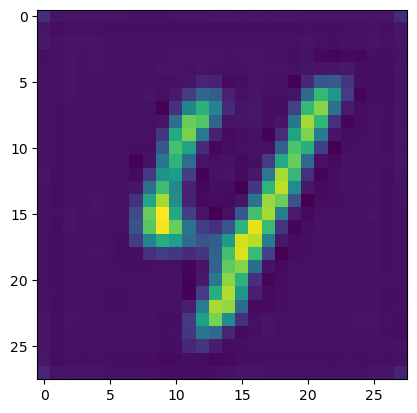

epoch: 1, step: 0, loss: 0.1329241394996643
epoch: 1, step: 200, loss: 0.12779375910758972
epoch: 1, step: 400, loss: 0.1238173171877861
epoch: 1, step: 600, loss: 0.12260113656520844
epoch: 1, step: 800, loss: 0.11228624731302261
epoch: 2, step: 0, loss: 0.11291974782943726
epoch: 2, step: 200, loss: 0.10583832859992981
epoch: 2, step: 400, loss: 0.10594911873340607
epoch: 2, step: 600, loss: 0.10606736689805984
epoch: 2, step: 800, loss: 0.09935535490512848
epoch: 3, step: 0, loss: 0.09843788295984268
epoch: 3, step: 200, loss: 0.09213054180145264
epoch: 3, step: 400, loss: 0.09401392936706543
epoch: 3, step: 600, loss: 0.08965153247117996
epoch: 3, step: 800, loss: 0.09859775006771088
epoch: 4, step: 0, loss: 0.08922116458415985
epoch: 4, step: 200, loss: 0.0899382010102272
epoch: 4, step: 400, loss: 0.08822781592607498
epoch: 4, step: 600, loss: 0.09553354233503342
epoch: 4, step: 800, loss: 0.08712819963693619
epoch: 5, step: 0, loss: 0.08469314873218536
epoch: 5, step: 200, loss:

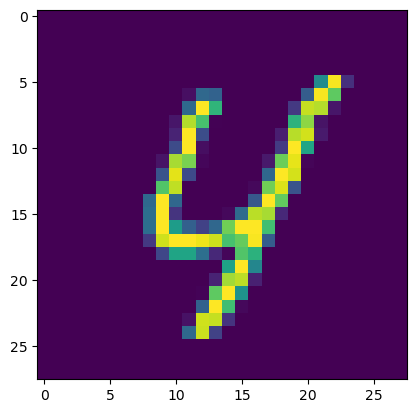

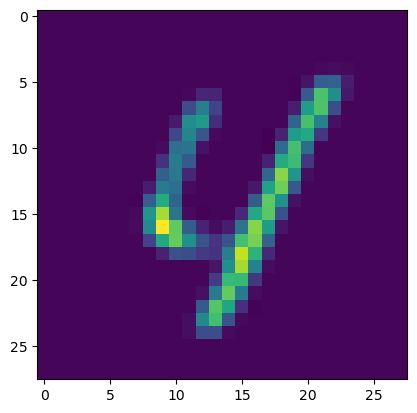

epoch: 6, step: 0, loss: 0.08087971806526184
epoch: 6, step: 200, loss: 0.07701759785413742
epoch: 6, step: 400, loss: 0.07756029069423676
epoch: 6, step: 600, loss: 0.08186464756727219
epoch: 6, step: 800, loss: 0.08004486560821533
epoch: 7, step: 0, loss: 0.07970065623521805
epoch: 7, step: 200, loss: 0.07568827271461487
epoch: 7, step: 400, loss: 0.07325601577758789
epoch: 7, step: 600, loss: 0.07654094696044922
epoch: 7, step: 800, loss: 0.0779489129781723
epoch: 8, step: 0, loss: 0.07607651501893997
epoch: 8, step: 200, loss: 0.08030056953430176
epoch: 8, step: 400, loss: 0.07922647148370743
epoch: 8, step: 600, loss: 0.07167340815067291
epoch: 8, step: 800, loss: 0.07257445901632309
epoch: 9, step: 0, loss: 0.07296192646026611
epoch: 9, step: 200, loss: 0.07398170232772827
epoch: 9, step: 400, loss: 0.07239866256713867
epoch: 9, step: 600, loss: 0.07161758840084076
epoch: 9, step: 800, loss: 0.07371541112661362
epoch: 10, step: 0, loss: 0.07710283994674683
epoch: 10, step: 200, l

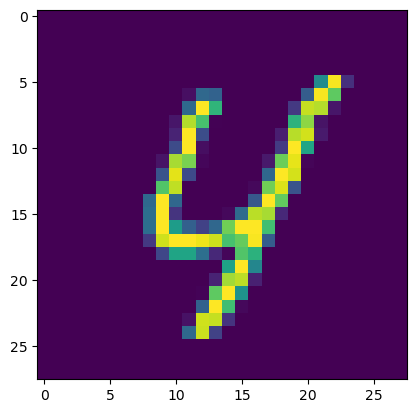

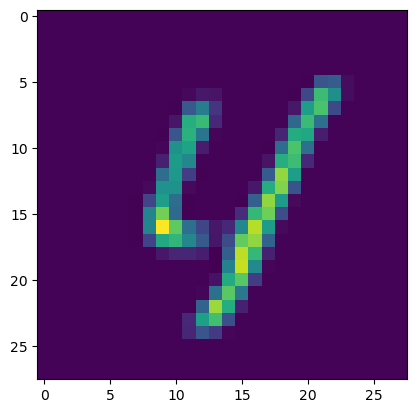

epoch: 11, step: 0, loss: 0.0730140432715416
epoch: 11, step: 200, loss: 0.07472199946641922
epoch: 11, step: 400, loss: 0.07435332983732224
epoch: 11, step: 600, loss: 0.07742920517921448
epoch: 11, step: 800, loss: 0.07268400490283966
epoch: 12, step: 0, loss: 0.06989814341068268
epoch: 12, step: 200, loss: 0.07656624913215637
epoch: 12, step: 400, loss: 0.0750763863325119
epoch: 12, step: 600, loss: 0.07261089980602264
epoch: 12, step: 800, loss: 0.07186302542686462
epoch: 13, step: 0, loss: 0.07182160019874573
epoch: 13, step: 200, loss: 0.07498473674058914
epoch: 13, step: 400, loss: 0.07357149571180344
epoch: 13, step: 600, loss: 0.07779812067747116
epoch: 13, step: 800, loss: 0.07024949043989182
epoch: 14, step: 0, loss: 0.07009296119213104
epoch: 14, step: 200, loss: 0.07394731789827347
epoch: 14, step: 400, loss: 0.07390643656253815
epoch: 14, step: 600, loss: 0.07392757385969162
epoch: 14, step: 800, loss: 0.0681881308555603
epoch: 15, step: 0, loss: 0.07815075665712357
epoch

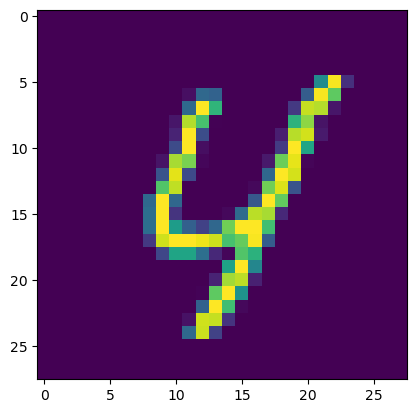

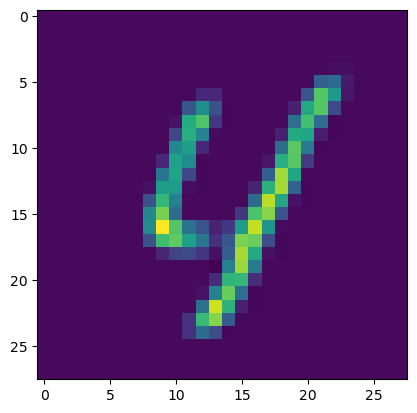

epoch: 16, step: 0, loss: 0.07138460129499435
epoch: 16, step: 200, loss: 0.07444408535957336
epoch: 16, step: 400, loss: 0.07267924398183823
epoch: 16, step: 600, loss: 0.07520754635334015
epoch: 16, step: 800, loss: 0.07714821398258209
epoch: 17, step: 0, loss: 0.06958512961864471
epoch: 17, step: 200, loss: 0.07049846649169922
epoch: 17, step: 400, loss: 0.06929455697536469
epoch: 17, step: 600, loss: 0.07271283119916916
epoch: 17, step: 800, loss: 0.06653697788715363
epoch: 18, step: 0, loss: 0.0726645439863205
epoch: 18, step: 200, loss: 0.07599277794361115
epoch: 18, step: 400, loss: 0.07238631695508957
epoch: 18, step: 600, loss: 0.07110778242349625
epoch: 18, step: 800, loss: 0.06896795332431793
epoch: 19, step: 0, loss: 0.07136674970388412
epoch: 19, step: 200, loss: 0.06526393443346024
epoch: 19, step: 400, loss: 0.0726422667503357
epoch: 19, step: 600, loss: 0.06802677363157272
epoch: 19, step: 800, loss: 0.06974126398563385


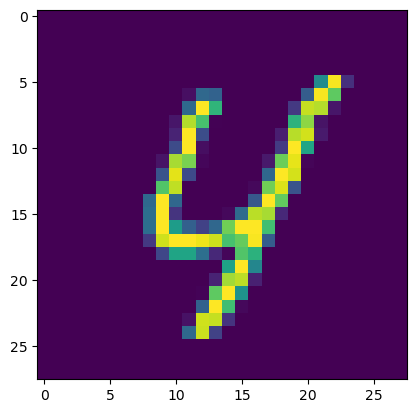

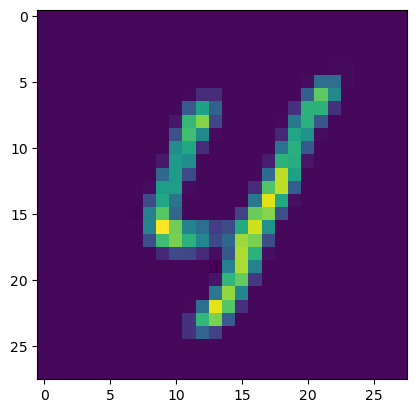

In [45]:
for epoch in range(n_epochs):
    model.train()
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model(inputs.to(device))
        loss = loss_func(inputs.to(device), predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    if epoch % 5 == 0 or epoch == n_epochs - 1:
        model.eval()
        item = dataset_test[555][0].unsqueeze(0).to(device).float()
        plt.imshow(dataset_test[555][0].squeeze().detach().numpy())
        plt.show()
        plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
        plt.show()

## Задание 2
Обучить VAE собственной архитектуры на MNIST

### Архитектура модели

In [46]:
class ConvVAEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 28x28
    self.do1 = nn.Dropout(0.2)
    
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 28x28
    self.do2 = nn.Dropout(0.2)   
    self.pool1 = nn.MaxPool2d(2, 2) # 14x14
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do3 = nn.Dropout(0.1)
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do4 = nn.Dropout(0.1)

    self.pool2 = nn.MaxPool2d(2, 2) # 7x7
    
    
    
    self.conv5_mu = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.conv5_sigma = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do2(self.activ(self.conv2(self.do1(self.activ(self.conv1(x)))))))
    x = self.pool2(self.do4(self.activ(self.conv4(self.do3(self.activ(self.conv3(x)))))))
    # для того, чтобы автокодировщик был вариационным, он должен выдавать mu и sigma
    mu = self.conv5_mu(x)
    sigma = torch.exp(self.conv5_sigma(x))      # exp больше нуля и используется для протекания градиента через ReLU

    return mu, sigma

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.do1 = nn.Dropout(0.1)

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.do2 = nn.Dropout(0.1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14x14       # обратная пулингу операция
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do3 = nn.Dropout(0.1)
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do4 = nn.Dropout(0.1)

    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    
    self.conv5 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1, 
                           padding=2) # 28x28
    self.activ = nn.ReLU()
  def forward(self, x):
    x = self.upsample1(self.do2(self.activ(self.conv2(self.do1(self.activ(self.conv1(x)))))))
    x = self.upsample2(self.do4(self.activ(self.conv4(self.do3(self.activ(self.conv3(x)))))))
    x = self.conv5(x)


    return x

# сэмплирование из полученных mu и sigma
def sampling(mu, sigma):
    return torch.normal(torch.zeros_like(mu), torch.ones_like(mu)) * sigma + mu

class ConvVAE(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvVAEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)


    return x_, mu, sigma    # модель возвращает mu и sigma для расчета расстояния кульбака-лейблера

### Гиперпараметры, загрузчик данных и формирование батча - из предыдущего задания

### Инициализация модели, задание оптимизатора и функции потерь

In [47]:
def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    return torch.distributions.kl_divergence(p, q).mean()

model = ConvVAE(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss() #TODO try to use MAE

### Трейн луп

epoch: 0, step: 0, loss: 0.9558532238006592
epoch: 0, step: 200, loss: 0.2673695981502533
epoch: 0, step: 400, loss: 0.291371613740921
epoch: 0, step: 600, loss: 0.2809772789478302
epoch: 0, step: 800, loss: 0.20051643252372742


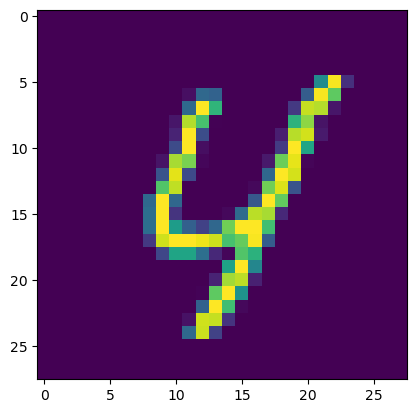

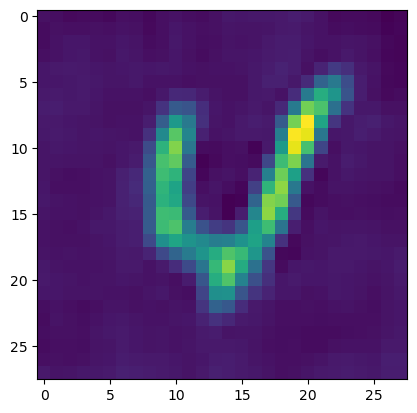

epoch: 1, step: 0, loss: 0.17246341705322266
epoch: 1, step: 200, loss: 0.16269251704216003
epoch: 1, step: 400, loss: 0.15515314042568207
epoch: 1, step: 600, loss: 0.14967025816440582
epoch: 1, step: 800, loss: 0.14862973988056183
epoch: 2, step: 0, loss: 0.14781756699085236
epoch: 2, step: 200, loss: 0.1419781744480133
epoch: 2, step: 400, loss: 0.14177754521369934
epoch: 2, step: 600, loss: 0.1423312872648239
epoch: 2, step: 800, loss: 0.133395254611969
epoch: 3, step: 0, loss: 0.13362863659858704
epoch: 3, step: 200, loss: 0.13144078850746155
epoch: 3, step: 400, loss: 0.13233785331249237
epoch: 3, step: 600, loss: 0.12849527597427368
epoch: 3, step: 800, loss: 0.12319247424602509
epoch: 4, step: 0, loss: 0.12911643087863922
epoch: 4, step: 200, loss: 0.1307447999715805
epoch: 4, step: 400, loss: 0.12971131503582
epoch: 4, step: 600, loss: 0.12681645154953003
epoch: 4, step: 800, loss: 0.1231810599565506
epoch: 5, step: 0, loss: 0.1233425959944725
epoch: 5, step: 200, loss: 0.1294

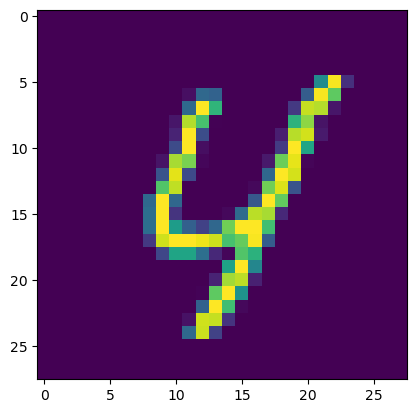

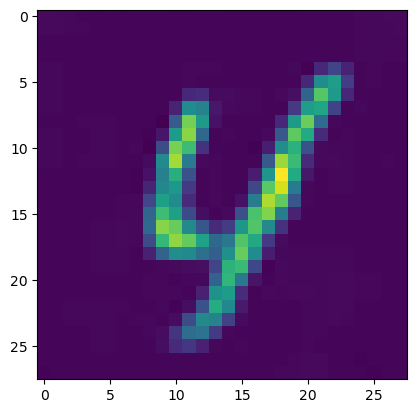

epoch: 6, step: 0, loss: 0.12032808363437653
epoch: 6, step: 200, loss: 0.12192657589912415
epoch: 6, step: 400, loss: 0.12463142722845078
epoch: 6, step: 600, loss: 0.11988595128059387
epoch: 6, step: 800, loss: 0.11719553172588348
epoch: 7, step: 0, loss: 0.11216843873262405
epoch: 7, step: 200, loss: 0.1167442575097084
epoch: 7, step: 400, loss: 0.11972789466381073
epoch: 7, step: 600, loss: 0.12018464505672455
epoch: 7, step: 800, loss: 0.12097401916980743
epoch: 8, step: 0, loss: 0.11341141164302826
epoch: 8, step: 200, loss: 0.11656509339809418
epoch: 8, step: 400, loss: 0.11329573392868042
epoch: 8, step: 600, loss: 0.11406409740447998
epoch: 8, step: 800, loss: 0.11852297186851501
epoch: 9, step: 0, loss: 0.1170802190899849
epoch: 9, step: 200, loss: 0.11624594032764435
epoch: 9, step: 400, loss: 0.11492353677749634
epoch: 9, step: 600, loss: 0.11280720680952072
epoch: 9, step: 800, loss: 0.10873042047023773
epoch: 10, step: 0, loss: 0.11655929684638977
epoch: 10, step: 200, lo

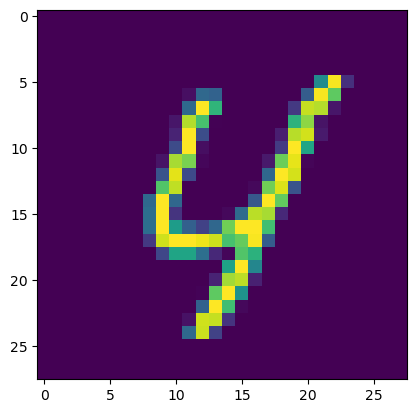

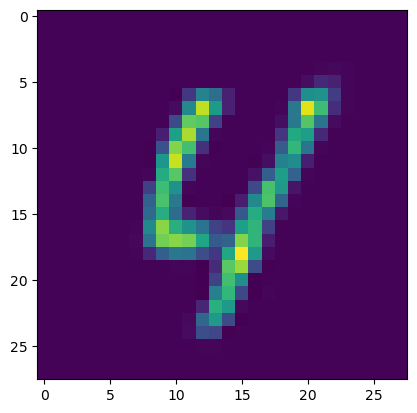

epoch: 11, step: 0, loss: 0.11087092757225037
epoch: 11, step: 200, loss: 0.11356614530086517
epoch: 11, step: 400, loss: 0.11221330612897873
epoch: 11, step: 600, loss: 0.11755172908306122
epoch: 11, step: 800, loss: 0.11494527012109756
epoch: 12, step: 0, loss: 0.11282940208911896
epoch: 12, step: 200, loss: 0.11017458140850067
epoch: 12, step: 400, loss: 0.11102352291345596
epoch: 12, step: 600, loss: 0.10973662883043289
epoch: 12, step: 800, loss: 0.10884708166122437
epoch: 13, step: 0, loss: 0.10889915376901627
epoch: 13, step: 200, loss: 0.1084558367729187
epoch: 13, step: 400, loss: 0.11287757754325867
epoch: 13, step: 600, loss: 0.10819132626056671
epoch: 13, step: 800, loss: 0.10730694979429245
epoch: 14, step: 0, loss: 0.10834670066833496
epoch: 14, step: 200, loss: 0.11317620426416397
epoch: 14, step: 400, loss: 0.11298049986362457
epoch: 14, step: 600, loss: 0.10553005337715149
epoch: 14, step: 800, loss: 0.10802854597568512
epoch: 15, step: 0, loss: 0.1094014048576355
epoc

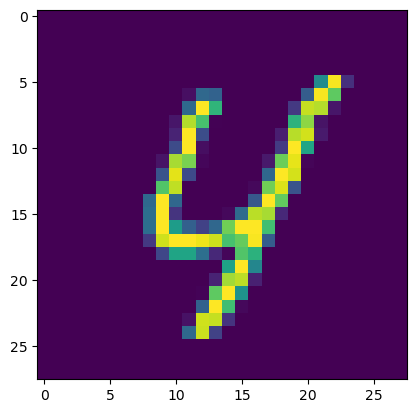

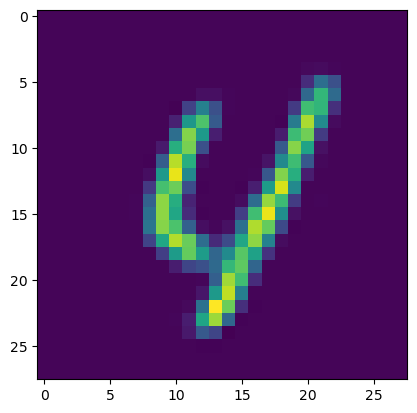

epoch: 16, step: 0, loss: 0.11014029383659363
epoch: 16, step: 200, loss: 0.11281055212020874
epoch: 16, step: 400, loss: 0.11127927154302597
epoch: 16, step: 600, loss: 0.10479482263326645
epoch: 16, step: 800, loss: 0.10753951966762543
epoch: 17, step: 0, loss: 0.1066160500049591
epoch: 17, step: 200, loss: 0.10702448338270187
epoch: 17, step: 400, loss: 0.1117936223745346
epoch: 17, step: 600, loss: 0.10323137044906616
epoch: 17, step: 800, loss: 0.10615485906600952
epoch: 18, step: 0, loss: 0.10907566547393799
epoch: 18, step: 200, loss: 0.11316787451505661
epoch: 18, step: 400, loss: 0.10694970190525055
epoch: 18, step: 600, loss: 0.1037084311246872
epoch: 18, step: 800, loss: 0.10722394287586212
epoch: 19, step: 0, loss: 0.10277698189020157
epoch: 19, step: 200, loss: 0.10998213291168213
epoch: 19, step: 400, loss: 0.11240894347429276
epoch: 19, step: 600, loss: 0.10851548612117767
epoch: 19, step: 800, loss: 0.10765647888183594


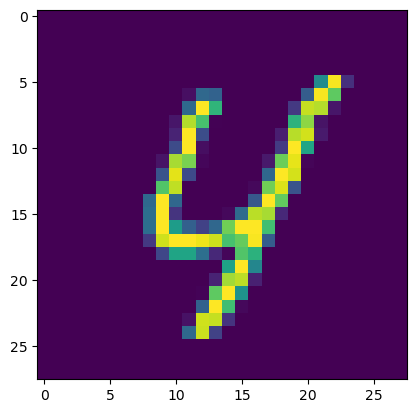

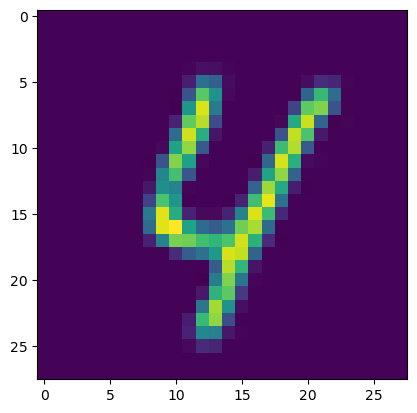

In [48]:
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        inputs = inputs.to(device)
        # noise_inputs = inputs + \
        # torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 0.7 
        predict, mu, sigma = model(inputs)
        # функция потерь с учетом расстояшия кульбака-лейблера
        loss = loss_func(inputs, predict) + 0.03 * kl_loss(mu, sigma)
        # четкость картинки можно регулировать расстоянием кульбака-лейблера (меньше - четче, но будеть меньше вариативности)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    if epoch % 5 == 0 or epoch == n_epochs - 1:
        item = dataset_test[555][0].unsqueeze(0).to(device).float()
        # item = item + torch.normal(torch.zeros_like(item), torch.ones_like(item)) * 0.7
        plt.imshow(item.squeeze().squeeze().cpu().detach().numpy())
        plt.show()
        plt.imshow(model(item)[0].squeeze().squeeze().cpu().detach().numpy())
        plt.show()

### Генерация вариаций элемента 555 выборки

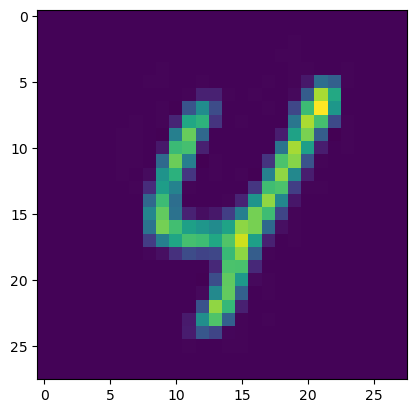

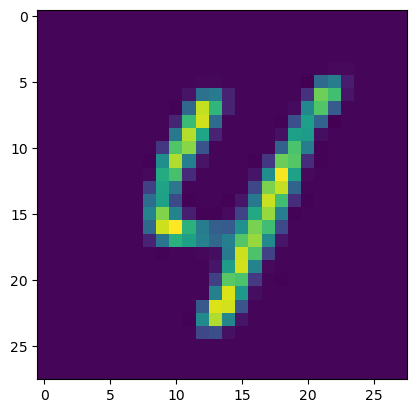

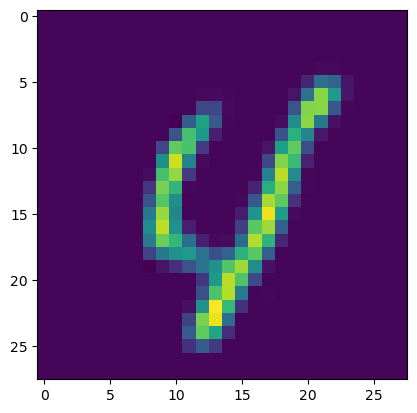

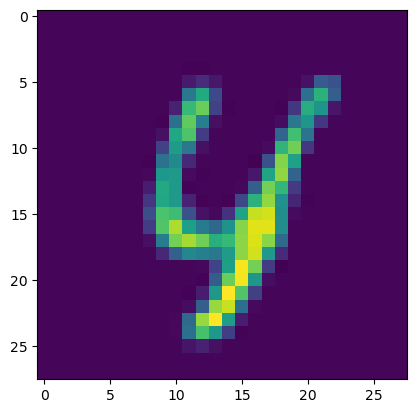

In [90]:
item = dataset_test[555][0].unsqueeze(0).to(device).float()
mu, sigma = model.encoder(item)

for _ in range(4):
    hid = torch.normal(torch.zeros((1,1,7,7)), torch.ones((1,1,7,7))).to(device) * 0.3 + mu     # умножаем на дисперсию

    plt.imshow(model.decoder(hid).squeeze().squeeze().cpu().detach().numpy())
    plt.show()